# Analysis of generated data

Analyze experiment results, present findings. Notebook input is data, output is A/B test suggestions.

Menu backed up on Github.

# Import libraries

In [87]:
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')  # plt.style.available

import warnings
warnings.filterwarnings("ignore")  # filter warnings

# Get data

Merge monthly order data into single .csv file. Raw files available on [Github](https://github.com/onederekchen/thaitanic/tree/main/data/raw_data).

In [88]:
path = "../data/raw_data/"

all_months_data = pd.DataFrame()

for file in os.listdir(path):
    if not file.startswith('.'):  # ignore hidden files
        current_month_data = pd.read_csv(path+file)
        all_months_data = pd.concat([all_months_data, current_month_data])

# remove unnamed column (fixed for future generations!)
all_months_data = all_months_data.loc[:, ~all_months_data.columns.str.contains('^Unnamed')]
    
# all_months_data.to_csv('all_data.csv', index=False)  # don't want to re-save csv every time

In [89]:
df = pd.read_csv("../data/all_data.csv").sort_values(by='Order Date', ascending=False)
df.reset_index(drop=True, inplace=True)
df

,Order ID,Product,Quantity Ordered,Price Each,Order Date
0,209412,Tom Yum Gai,1,12,2019-12-31 20:59:00
1,209411,Pad Kee Mao,1,12,2019-12-31 20:57:00
2,209397,Yellow Curry,1,12,2019-12-31 20:55:00
3,209417,Thai Fried Rice,1,12,2019-12-31 20:53:00
4,209402,Yum Woonsen,2,13,2019-12-31 20:51:00
...,...,...,...,...,...
216487,3925,Pad Char,1,15,2017-01-01 12:15:00
216488,3926,Sriracha Wings,1,10,2017-01-01 12:08:00
216489,3913,Grilled Salmon,1,22,2017-01-01 12:07:00
216490,3931,Pad Kee Mao,1,12,2017-01-01 12:06:00


# Clean data

In [90]:
df.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
dtype: int64

In [91]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

df.dtypes

Order ID                     int64
Product                     object
Quantity Ordered             int64
Price Each                   int64
Order Date          datetime64[ns]
dtype: object

# Augment data

In [92]:
df['Sales'] = df['Quantity Ordered'] * df['Price Each']

df['Year'] = df['Order Date'].dt.year

df['Month'] = df['Order Date'].dt.month

df['Weekday'] = df['Order Date'].dt.day_name()

df['Hour'] = df['Order Date'].dt.hour

# Explore data

In [35]:
df.describe()

,Order ID,Quantity Ordered,Price Each,Sales,Year,Month,Hour
count,216492.000000,216492.000000,216492.000000,216492.000000,216492.000000,216492.000000,216492.000000
mean,106655.919203,1.125427,12.202977,13.733782,2018.009455,6.829329,15.861454
std,59347.187553,0.684673,3.075631,9.269607,0.817747,3.498833,2.958466
min,3910.000000,1.000000,6.000000,6.000000,2017.000000,1.000000,11.000000
25%,55261.750000,1.000000,12.000000,12.000000,2017.000000,4.000000,13.000000
50%,106677.500000,1.000000,12.000000,12.000000,2018.000000,7.000000,17.000000
75%,158065.250000,1.000000,12.000000,12.000000,2019.000000,10.000000,19.000000
max,209428.000000,9.000000,22.000000,198.000000,2019.000000,12.000000,20.000000


We see the lowest Order ID is 3910 - maybe Thaitanic started recording data (or switched to a new system) in December 2016, and just gave us data from January 2017 onwards.

Also we see that at least 75% of order quantites are just one order (but someone ordered 9 somewhere! Maybe catering or some other large takeout option? It actually looks like the biggest sale ever was the most expensive item purchased 9 times... so might be an anomaly). 

And we see the cheapest item is six dollars while the most expensive is 22.

### Duplicate values

In [76]:
dupes_df = df.loc[(df['Order ID'].duplicated(keep=False))]
dupes_df

# check for more than 2 dupes in one order (none found)
# grouped_df = df.groupby('Order ID').count()
# grouped_df.loc[(grouped_df['Product'])>2]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Hour
9,209426,Thai Fried Rice,1,12,2019-12-31 20:32:00,12,2019,12,Tuesday,20
11,209426,Sticky Rice with Mango,1,6,2019-12-31 20:32:00,6,2019,12,Tuesday,20
12,209427,Green Curry,1,12,2019-12-31 20:29:00,12,2019,12,Tuesday,20
13,209427,Sticky Rice with Mango,1,6,2019-12-31 20:29:00,6,2019,12,Tuesday,20
32,209418,Thai Beef Noodle Soup,1,12,2019-12-31 20:05:00,12,2019,12,Tuesday,20
...,...,...,...,...,...,...,...,...,...,...
216465,3924,Sticky Rice with Mango,3,6,2017-01-01 12:57:00,18,2017,1,Sunday,12
216476,3927,Grilled Salmon,1,22,2017-01-01 12:34:00,22,2017,1,Sunday,12
216478,3927,Sticky Rice with Mango,1,6,2017-01-01 12:34:00,6,2017,1,Sunday,12
216484,3922,Pad Thai,1,12,2017-01-01 12:17:00,12,2017,1,Sunday,12


The duplicate values look like a second item ordered within the same product ID. So there aren't erroneous duplicates, it's part of the order. Also, there aren't any orders with 3 or more items.

In [81]:
dupes_df.groupby('Product').sum().sort_values(by='Quantity Ordered', ascending=False)

,Order ID,Quantity Ordered,Price Each,Sales,Year,Month,Hour
Product,,,,,,,
Sticky Rice with Mango,1167497683,12385,66180,74310,22258568,74653,175494
Chicken Satay,81713731,876,7650,8760,1543786,5134,12085
Vegan Fresh Rolls,68330204,723,6260,7230,1263295,4280,9797
Green Curry,57636253,612,6468,7344,1087707,3701,8653
Pad Thai,57003653,603,6564,7236,1103837,3673,8617
Red Curry,57511036,589,6480,7068,1089732,3589,8559
Thai Beef Noodle Soup,54740199,577,6180,6924,1039275,3473,8161
Thai Fried Rice,52962091,571,6180,6852,1039256,3400,8183
Yellow Curry,51862427,567,5976,6804,1004949,3419,7853


Okay, the dupes are overwhelmingly the only dessert item on the menu. There's a drop off in other dishes, but it might just be related to the popularity of those items. What about orders that don't include sticky rice with mango?

In [103]:
# did i do this right? i just wanted to remove anything that was paired with sticky rice. so see things that aren't paired with it.

dupes_no_sticky_rice = df.loc[(df['Order ID'].duplicated(keep=False) & ~(df['Product'].str[0:6]=="Sticky"))]
remaining_dupes = dupes_no_sticky_rice.loc[(dupes_no_sticky_rice['Order ID'].duplicated(keep=False))]
remaining_dupes

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Hour
113,209322,Green Curry,1,12,2019-12-31 17:51:00,12,2019,12,Tuesday,17
114,209322,Vegan Fresh Rolls,1,10,2019-12-31 17:51:00,10,2019,12,Tuesday,17
330,209104,Red Curry,1,12,2019-12-29 19:30:00,12,2019,12,Sunday,19
332,209104,Chicken Satay,1,10,2019-12-29 19:30:00,10,2019,12,Sunday,19
535,208892,Sriracha Wings,1,10,2019-12-29 13:45:00,10,2019,12,Sunday,13
...,...,...,...,...,...,...,...,...,...,...
215094,5224,Vegan Fresh Rolls,1,10,2017-01-08 15:50:00,10,2017,1,Sunday,15
215382,4973,Chicken Satay,1,10,2017-01-07 14:23:00,10,2017,1,Saturday,14
215383,4973,Yum Nua,1,12,2017-01-07 14:23:00,12,2017,1,Saturday,14
216101,4280,MyThai Salad,1,12,2017-01-03 18:39:00,12,2017,1,Tuesday,18


Looks like it was mostly sticky rice, but there are still other duplicate orders which isn't unusual. Actually, I'm noticing a lot of these seem to be appetizers - let's see if there's a noticeable difference in the amount of appetizers vs other meals.

In [104]:
# duplicate pairings including an appetizer (886)
remaining_dupes.loc[(remaining_dupes['Product'].str[0:5]=="Tom K") | 
                   (remaining_dupes['Product'].str[0:5]=="Srira") | 
                   (remaining_dupes['Product'].str[0:5]=="Chick") | 
                   (remaining_dupes['Product'].str[0:5]=="Vegan")]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Hour
114,209322,Vegan Fresh Rolls,1,10,2019-12-31 17:51:00,10,2019,12,Tuesday,17
332,209104,Chicken Satay,1,10,2019-12-29 19:30:00,10,2019,12,Sunday,19
535,208892,Sriracha Wings,1,10,2019-12-29 13:45:00,10,2019,12,Sunday,13
592,208860,Sriracha Wings,1,10,2019-12-29 12:44:00,10,2019,12,Sunday,12
737,208711,Chicken Satay,1,10,2019-12-28 18:37:00,10,2019,12,Saturday,18
...,...,...,...,...,...,...,...,...,...,...
215057,5265,Tom Kha Gai,1,12,2017-01-08 17:53:00,12,2017,1,Sunday,17
215093,5224,Vegan Fresh Rolls,1,10,2017-01-08 15:50:00,10,2017,1,Sunday,15
215094,5224,Vegan Fresh Rolls,1,10,2017-01-08 15:50:00,10,2017,1,Sunday,15
215382,4973,Chicken Satay,1,10,2017-01-07 14:23:00,10,2017,1,Saturday,14


In [106]:
# duplicate pairings not including an appetizer (740)
remaining_dupes.loc[~(remaining_dupes['Product'].str[0:5]=="Tom K") & 
                   ~(remaining_dupes['Product'].str[0:5]=="Srira") & 
                   ~(remaining_dupes['Product'].str[0:5]=="Chick") & 
                   ~(remaining_dupes['Product'].str[0:5]=="Vegan")]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Hour
113,209322,Green Curry,1,12,2019-12-31 17:51:00,12,2019,12,Tuesday,17
330,209104,Red Curry,1,12,2019-12-29 19:30:00,12,2019,12,Sunday,19
536,208892,Waterfall Mushroom and Tofu,1,12,2019-12-29 13:45:00,12,2019,12,Sunday,13
593,208860,Thai Streetfood Noodle,1,12,2019-12-29 12:44:00,12,2019,12,Sunday,12
736,208711,Red Curry,1,12,2019-12-28 18:37:00,12,2019,12,Saturday,18
...,...,...,...,...,...,...,...,...,...,...
214279,5976,Yum Woonsen,1,13,2017-01-13 18:55:00,13,2017,1,Friday,18
214807,5508,Thai Fried Rice,1,12,2017-01-10 19:20:00,12,2017,1,Tuesday,19
215055,5265,Pad Gra Tiem,1,15,2017-01-08 17:53:00,15,2017,1,Sunday,17
215383,4973,Yum Nua,1,12,2017-01-07 14:23:00,12,2017,1,Saturday,14


Doesn't look like there's a significant difference in multiple items in an order aside from the dessert pairing.

##### So our finding is that people frequently order the dessert, and that people don't pair the appetizers any more than regular meals.

Maybe we can include this as a combo to encourage people to buy more expensive items, or to buy appetizers which don't seem to be especially popular as a pairing.



### Item popularity

Look at item popularity, if there's something consistently not popular, maybe they should just get rid of it. That one doesn't even need to be tested.

In [109]:
df.groupby('Product').sum().sort_values(by='Quantity Ordered', ascending=False)

,Order ID,Quantity Ordered,Price Each,Sales,Year,Month,Hour
Product,,,,,,,
Sticky Rice with Mango,2187364990,23046,123654,138276,41589043,140192,327531
Green Curry,1201885300,12617,134496,151404,22617922,76802,177825
Red Curry,1193923204,12617,134328,151404,22589626,76141,177740
Pad Thai,1198912015,12525,134184,150300,22565437,76881,177113
Yellow Curry,1164475844,12439,131640,149268,22137482,74939,174243
Thai Beef Noodle Soup,1080953139,11452,122256,137424,20559402,69523,161660
Thai Streetfood Noodle,1074347301,11322,120480,135864,20260857,68674,159020
Thai Fried Rice,1060043663,11244,120900,134928,20331283,68195,159921
Grilled Salmon,1052722153,11092,218108,244024,20006436,68303,156924


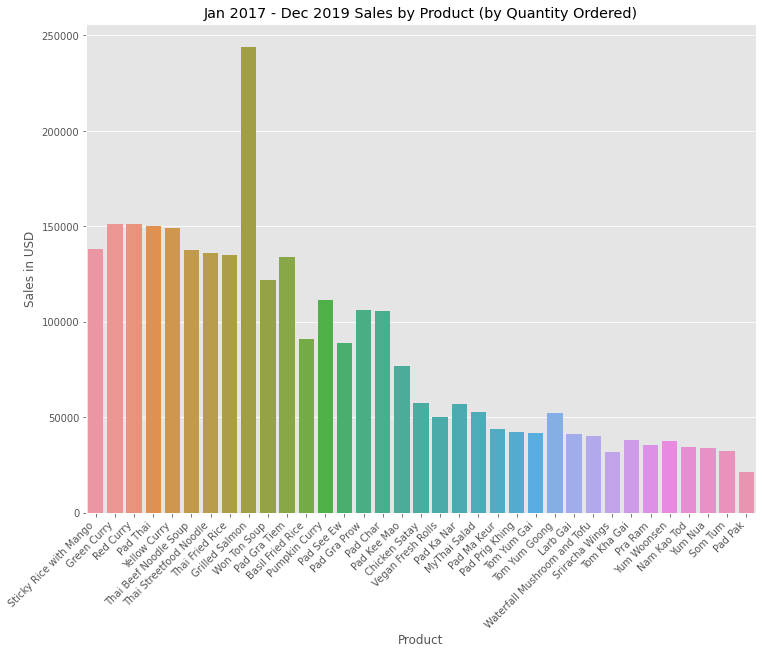

In [118]:
# probably graph this to make it easier to see...

product_popularity = df.groupby('Product').sum().sort_values(by='Quantity Ordered', ascending=False)

plt.figure(figsize=(12,9))
ax = sns.barplot(product_popularity.index, product_popularity['Sales'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Jan 2017 - Dec 2019 Sales by Product (by Quantity Ordered)")
plt.ylabel("Sales in USD");

Looks like there's a lot of variation. Also noticing that dishes with non-English names seem to not be selling as well. Might be an idea to switch them to english names?

This is an expenses thing, but it might be a easy change to stop offering the less popular dishes. A bigger menu gives people more variety which is almost never a bad thing, but it's expensive to stock that many different kinds of ingredients.

Maybe remove the least purchased dishes from the menu? Would need some information on how expensive it is to stock/prepare each item, but the business could become more lean this way.

(?) What's the value prop? Is it important to have such variety, or could they focus on doing a few dishes really really well?

Maybe pair the most popular dish with some less popular dishes (to encourage people to try other stuff).

Alternatively, you could pair the most popular dish as a combo with even more popular dishes to get people to buy more. But you might be able to increase overall demand like this. The Bay Area has foodie culture, and if you're known for top tier Thai food and good prices, people will make the trip. In this case, you might want to consider some marketing stuff too.

NOTE: there's an infinite amount of analysis you could do here - you could annotate every dish in the menu with coconut and sort by that if you wanted to. Follow your hunches to avoid being distracted by less important stuff.

### Quantity Ordered?

In [38]:
more_than_one_ordered = df.loc[(df['Quantity Ordered'] > 1)]
one_ordered = df.loc[(df['Quantity Ordered'] == 1)]
# len(more_than_one_ordered) + len(one_ordered)
print(len(more_than_one_ordered) / (len(one_ordered) +len(more_than_one_ordered))*100)
more_than_one_ordered

6.55128134065


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Hour
4,209402,Yum Woonsen,2,13,2019-12-31 20:51:00,26,2019,12,Tuesday,20
45,209376,Chicken Satay,2,10,2019-12-31 19:41:00,20,2019,12,Tuesday,19
48,209359,Pad Gra Prow,2,15,2019-12-31 19:38:00,30,2019,12,Tuesday,19
51,209364,Yum Woonsen,3,13,2019-12-31 19:36:00,39,2019,12,Tuesday,19
62,209394,Pumpkin Curry,2,15,2019-12-31 19:25:00,30,2019,12,Tuesday,19
...,...,...,...,...,...,...,...,...,...,...
216429,3978,Thai Streetfood Noodle,9,12,2017-01-01 14:05:00,108,2017,1,Sunday,14
216450,3958,Thai Fried Rice,2,12,2017-01-01 13:18:00,24,2017,1,Sunday,13
216458,3948,Basil Fried Rice,7,12,2017-01-01 13:04:00,84,2017,1,Sunday,13
216464,3924,Sticky Rice with Mango,3,6,2017-01-01 12:57:00,18,2017,1,Sunday,12


We see that about 6.5% of orders have have more than one item ordered.

### Do they have anything in common? Maybe this could inform combos / discounts?

In [111]:
df.groupby('Quantity Ordered').count()

,Order ID,Product,Price Each,Order Date,Sales,Year,Month,Weekday,Hour
Quantity Ordered,,,,,,,,,
1,202309,202309,202309,202309,202309,202309,202309,202309,202309
2,10917,10917,10917,10917,10917,10917,10917,10917,10917
3,474,474,474,474,474,474,474,474,474
4,485,485,485,485,485,485,485,485,485
5,479,479,479,479,479,479,479,479,479
6,460,460,460,460,460,460,460,460,460
7,444,444,444,444,444,444,444,444,444
8,438,438,438,438,438,438,438,438,438
9,486,486,486,486,486,486,486,486,486


#### (!) Seeing something funny here: there are as many people ordering 9 quantity as there are ordering 3. Seems fishy. Is now the time to fix that? Do I just ignore it?

Let's assume I just didn't find anything useful in quantity ordered.

# Best, worst months of sales?

Do I care about sales or orders? Probably sales, right? Because orders just influence sales?

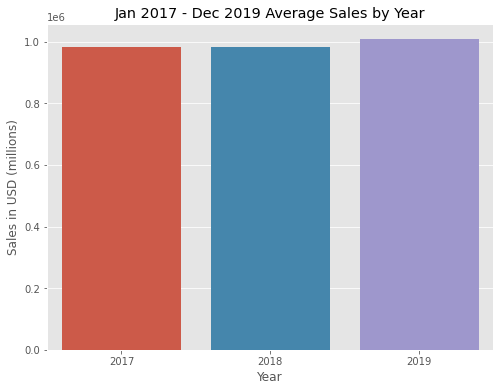

In [39]:
year_sales = df.groupby('Year').sum()

plt.figure(figsize=(8,6))
ax = sns.barplot(year_sales.index, year_sales['Sales'])

plt.title("Jan 2017 - Dec 2019 Average Sales by Year")
plt.ylabel("Sales in USD (millions)");

Sales look similar between years. Trending upwards, but not significantly enough to note. 2019's sales are 1% higher than 2017's (+$26077 in net sales).

This isn't a new restaurant, so it's likely the demand has settled to the market. It's beyond the scope of this analysis, but you could look at trends for other restaurants in the area to get an idea of how much the area affects sales (as opposed to effort from the restaurant team). 

2019 is also the first year the restaurant exceeded $1M in annual sales. Congrats!

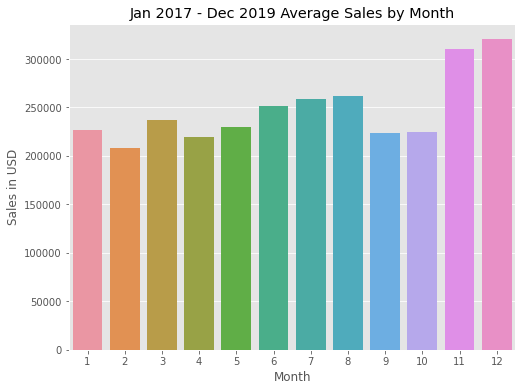

In [95]:
month_sales = df.groupby('Month').sum()

plt.figure(figsize=(8,6))
ax = sns.barplot(month_sales.index, month_sales['Sales'])

plt.title("Jan 2017 - Dec 2019 Average Sales by Month")
plt.ylabel("Sales in USD");

There's some variation between monthly sales, but not enough to draw any conclusions other than that November and December have way higher sales. Maybe June/July/August have a slight uptick which doesn't seem unreasonable because of nicer weather and summer break. And maybe September/October have lower values because it's getting colder and people are saving for winter months? 

Let's look by year and by month.

In [41]:
# by year then by month?

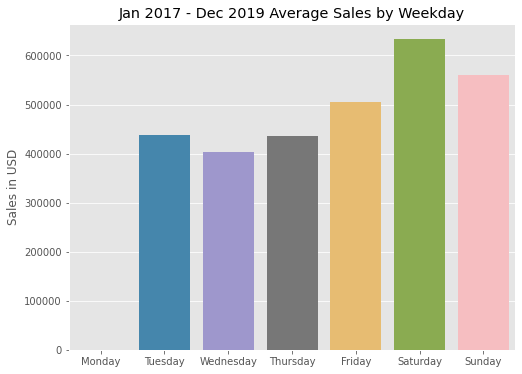

In [94]:
weekday_sales = df.groupby('Weekday').sum()

weekdays = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  # closed on Mondays
weekday_values = ['Monday']
weekday_sales_values = [0]

for weekday in weekdays:
    weekday_values.append(weekday)
    weekday_sales_values.append(weekday_sales.loc[(weekday_sales.index == weekday)]['Sales'].values[0])

plt.figure(figsize=(8,6))
ax = sns.barplot(weekday_values, weekday_sales_values)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Jan 2017 - Dec 2019 Average Sales by Weekday")
plt.ylabel("Sales in USD");

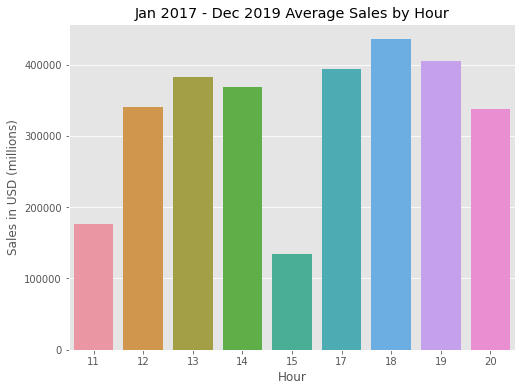

In [43]:
hour_sales = df.groupby('Hour').sum()

plt.figure(figsize=(8,6))
ax = sns.barplot(hour_sales.index, hour_sales['Sales'])

plt.title("Jan 2017 - Dec 2019 Average Sales by Hour")
plt.ylabel("Sales in USD (millions)");

This is cool but doesn't tell us much because different weekdays have different hours. We could estimate by adding the 15:00 bar to the 11:00 bar, but we can do better than that.

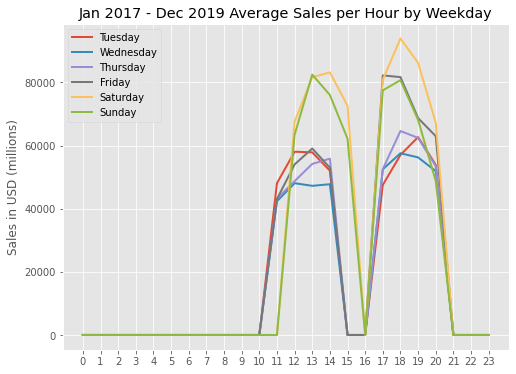

In [44]:
weekdays = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(8,6))

for weekday in weekdays:
    day_sales_filtered = df.loc[(df['Weekday'] == weekday)]
    day_sales = day_sales_filtered.groupby('Hour').sum()
    day_values = []
    for hour in range(0,24):
        if hour not in day_sales.index:
            day_values.append(0)
        else:
            day_values.append(day_sales["Sales"][hour])
    ax = sns.lineplot(x=range(0,24), y=day_values, label=weekday, linewidth=2)

plt.xticks(range(0,24))
plt.ylabel("Sales in USD (millions)")
plt.title("Jan 2017 - Dec 2019 Average Sales per Hour by Weekday");

# plt.savefig("2019_Sales.png", dpi=100, bbox_inches='tight')

We can see here that Wednesday is pretty much the lowest day (even lower than Tuesday or Thursday), so maybe switching the off day from Monday to Wednesday might be something to try.

At a glance, you might consider changing up weekday hours from 11am-3pm to 12pm-4pm since the sales are higher there. But we can be pretty sure that weekend hours and customer availability are much better on weekends.

Maybe remove the least purchased dishes from the menu? Would need some information on how expensive it is to stock/prepare each item, but the business could become more lean this way.

(?) What's the value prop? Is it important to have such variety, or could they focus on doing a few dishes really really well?

Maybe pair the most popular dish with some less popular dishes (to encourage people to try other stuff).

Alternatively, you could pair the most popular dish as a combo with even more popular dishes to get people to buy more. But you might be able to increase overall demand like this. The Bay Area has foodie culture, and if you're known for top tier Thai food and good prices, people will make the trip. In this case, you might want to consider some marketing stuff too.

### Conceptualize restaurant revenue model --> move downwards after exploration complete!

### (?) We can use a conceptual model of the restaurant's revenue to check we haven't missed anything huge.

Now that we've seen the data, let's build a basic business model so we have an idea of what to look for. The restaurant's revenue model can be conceptualized as a product of two major factors:
1. How many people eat at the restaurant? (How many orders will it get?)
2. What do those customers eat? (How much is each order worth?)

We can create a basic revenue model by considering the drivers of those two factors. (Red notes drivers we can directly affect). 

![](revenue_model.jpg)

Here are some questions that might be helpful to think about during our initial exploration:
* What hours are the best? (check against sales and orders)
* What items are the most popular? (We can try combo meals instead of simply dropping prices)
##### (?) if we increase value offered, will the cost/order go up?

It's out of scope for this notebook, but you could also consider deeper analysis such as:
* Market trends in the area
* Competitive analysis on other restaurants in the area, especially Thai restaurants
* Does the ordering of the menu items affect the menu?

# A/B Test suggestions

1. Close on Wednesdays instead of Mondays (if you were really worried, you could try staying open 7 days/week, but I recognize that's not realistic).
2. Offer combos?

# Non-test recommendations (!) Give insights, ordered recommendations, and suggestions for things to test.

1. Stop offering so many items.
2. Note which items are vegan/vegetarian.


Note on combos: Offering combos increases the value proposition, which might increase the sales from customers who are already in the restaurant. But to really make it worth it (cost-benefit analysis the 'worth-it' here because it might be worth it with that alone), you would want to engage in some kind of marketing, or way to amplify the customers who make it to your store. Marketing your value proposition.

# NOTES

I'm just exploring the data. Is there anything specific I can already look for?

1. Sales (break down by times?)

(?) should PRODUCT column just be 'Order' or 'Item'?

(!) order date is time accurate, not order ID... woops.